In [ ]:
%cd /content/drive/MyDrive/ODM

In [ ]:
!pip install tensorflow-gpu

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
!git clone https://github.com/tensorflow/models.git

In [ ]:
pwd

In [ ]:
cd /content/drive/MyDrive/ODM/models/research

In [ ]:
pwd

In [ ]:
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git

In [ ]:
cd /content/drive/MyDrive/ODM/models/research/cocoapi/PythonAPI

In [ ]:
!make

In [ ]:
cp -r pycocotools /content/drive/MyDrive/ODM/models/research

In [ ]:
cd  ..

In [ ]:
cd  ..

In [ ]:
cp object_detection/packages/tf2/setup.py .

In [ ]:
!python -m pip install .

In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

In [ ]:
cd /content/drive/MyDrive/training_demo/pre-trained-models

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

In [ ]:
!tar -xvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

In [ ]:
pwd

In [ ]:
cd /content/drive/MyDrive/training_demo

In [ ]:
# Create train data:
!python generate_tfrecord.py -x /content/drive/MyDrive/training_demo/images/train
-l /content/drive/MyDrive/training_demo/annotations/label_map.pbtxt
-o /content/drive/MyDrive/training_demo/annotations/train.record

# Create test data:
!python generate_tfrecord.py -x /content/drive/MyDrive/training_demo/images/test
-l /content/drive/MyDrive/training_demo/annotations/label_map.pbtxt
-o /content/drive/MyDrive/training_demo/annotations/test.record

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
pwd

In [ ]:
!python model_main_tf2.py --model_dir=/content/drive/MyDrive/training_demo/models/my_model
--pipeline_config_path=/content/drive/MyDrive/training_demo/models/my_model/pipeline.config

In [ ]:
!python model_main_tf2.py --model_dir=/content/drive/MyDrive/training_demo/models/my_model
--pipeline_config_path=/content/drive/MyDrive/training_demo/models/my_model/pipeline.config
--checkpoint_dir=/content/drive/MyDrive/training_demo/models/my_model

In [ ]:
!python exporter_main_v2.py --input_type image_tensor
--pipeline_config_path /content/drive/MyDrive/training_demo/models/my_model/pipeline.config
--trained_checkpoint_dir /content/drive/MyDrive/training_demo/models/my_model
--output_directory /content/drive/MyDrive/training_demo/exported-models/model2

Loading model...Done! Took 10.807332992553711 seconds
Running inference for /content/drive/MyDrive/training_demo/images/test/0000368_02200_d_0000240.jpg... Done


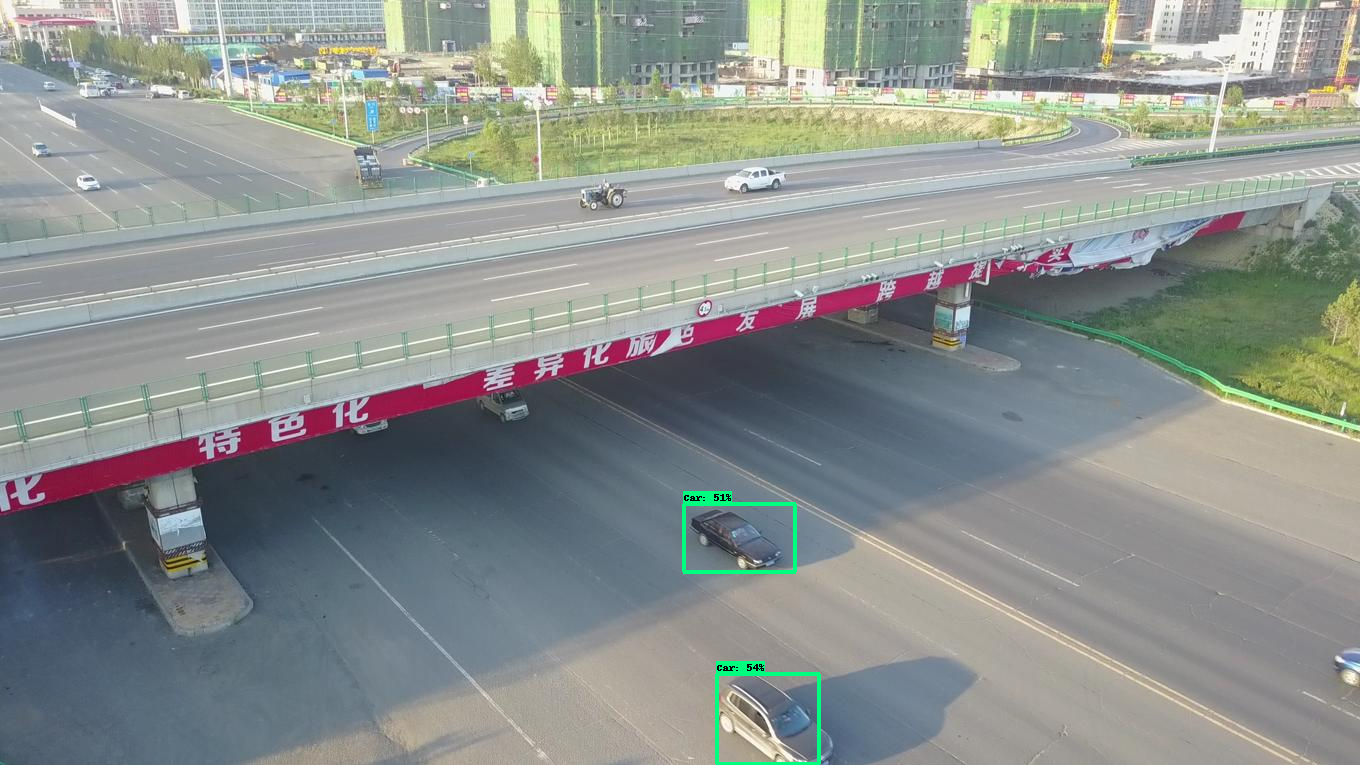

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pathlib
import tensorflow as tf
import cv2
import argparse
from google.colab.patches import cv2_imshow

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# PROVIDE PATH TO IMAGE DIRECTORY
IMAGE_PATHS = '/content/drive/MyDrive/training_demo/images/test/0000368_02200_d_0000240.jpg'


# PROVIDE PATH TO MODEL DIRECTORY
PATH_TO_MODEL_DIR = '/content/drive/MyDrive/training_demo/exported-models/model1'

# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = '/content/drive/MyDrive/training_demo/annotations/label_map.pbtxt'


MIN_CONF_THRESH = float(0.60)

# LOAD THE MODEL

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()


detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))



category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def load_image_into_numpy_array(path):
    return np.array(Image.open(path))


print('Running inference for {}... '.format(IMAGE_PATHS), end='')

image = cv2.imread(IMAGE_PATHS)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)
input_tensor = tf.convert_to_tensor(image)
input_tensor = input_tensor[tf.newaxis, ...]
detections = detect_fn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_with_detections = image.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.5,
      agnostic_mode=False)

print('Done')
# DISPLAYS OUTPUT IMAGE
cv2_imshow(image_with_detections)

